In [1]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pointbiserialr, pearsonr

##### Initialize datatables

In [2]:
# data
field_data = pd.read_csv('HABs2022_FieldData.csv')
field_data = duckdb.sql("""SELECT Sample_ID, Location, Site_Name, Site_ID, Lat, Long, Sampling_Date, Sampling_Time, Timezone, USGS_siteno, "Avg_SpecConductance (uS/cm)" AS AvgSCond, Notes 
                    FROM field_data""").df()

sample_mastersheet = pd.read_csv('HABs2022_SampleMastersheet.csv')

# map
states = gpd.read_file("states/cb_2018_us_state_500k.shp")
states = states[~states.STUSPS.isin(["AK", "AS", "GU", "HI", "MP", "PR", "VI"])]
states = states.to_crs("EPSG:4326")
oregon = states[states['STUSPS'] == 'OR']
w_virginia = states[states["STUSPS"] == 'WV']

In [3]:
# isolate specific conductance data and combine with sample_mastersheet to match taxa with location
cond_data = duckdb.sql("""SELECT field_data.Sample_ID, field_data.Location, field_data.Long, field_data.Lat, field_data.AvgSCond, sample_mastersheet."Morphological ID" as Morphological_ID 
                       FROM sample_mastersheet LEFT JOIN field_data ON field_data.Sample_ID = sample_mastersheet.Sample_ID""").df()
cond_data

,Sample_ID,Location,Long,Lat,AvgSCond,Morphological_ID
0,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Gloeotrichia
1,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Aphanizomenon
2,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Dolichospermum
3,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Gloeotrichia
4,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Aphanizomenon
...,...,...,...,...,...,...
309,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium
310,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium
311,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium
312,FRRA_H,"McKenzie River, OR",-122.368061,44.142939,53.5,Tribonema


In [4]:
# add counts of how many times each taxa appears per Sample_ID per Location
cond_morph_with_counts = cond_data.copy()
cond_morph_with_counts['Count']=cond_morph_with_counts.groupby(['Sample_ID', 'Location', 'Morphological_ID']).transform('size')

# get counts of how many samples were collected at each sample_id
sample_counts = duckdb.sql("""SELECT Sample_ID, COUNT() as Count 
                           FROM cond_data 
                           GROUP BY Sample_ID""").df()

# add sample_counts counts to field_data, which has one row per sample_id
cond_data_with_counts = duckdb.sql("""SELECT * EXCLUDE sample_counts.Sample_ID
                                    FROM field_data LEFT JOIN sample_counts ON field_data.Sample_ID = sample_counts.Sample_ID""").df().fillna(0)

In [70]:
cond_morph_with_counts[cond_morph_with_counts['AvgSCond'] > 400]['Morphological_ID']

101     Aphanizomenon
102     Aphanizomenon
103     Aphanizomenon
104       Microcystis
105       Microcystis
106    Dolichospermum
107       Microcystis
108     Aphanizomenon
109       Microcystis
110     Aphanizomenon
111       Microcystis
169      Oscillatoria
170      Oscillatoria
171      Oscillatoria
172      Oscillatoria
173      Oscillatoria
174      Oscillatoria
175      Oscillatoria
176      Oscillatoria
184      Oscillatoria
185      Oscillatoria
186      Oscillatoria
187      Oscillatoria
188      Oscillatoria
189      Oscillatoria
190      Oscillatoria
191      Oscillatoria
192      Oscillatoria
Name: Morphological_ID, dtype: object

##### Plots

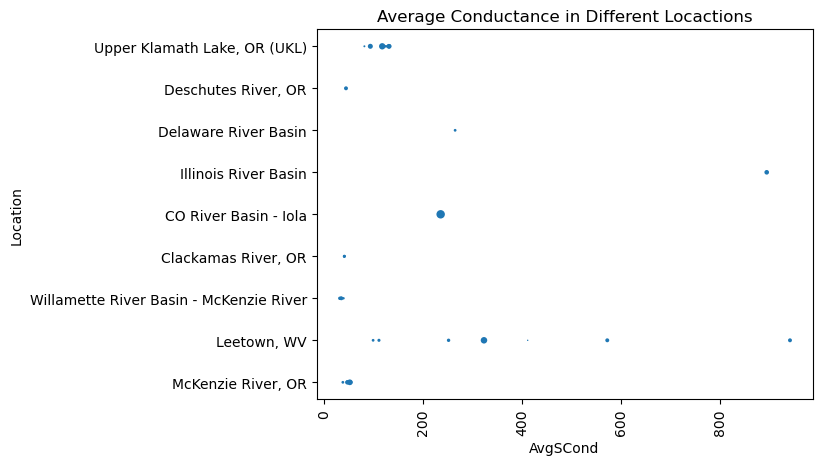

In [5]:
# NOT USED
# plot of specific conductance by location, size of plot determined by how many samples were taken there
sns.scatterplot(cond_data_with_counts, y='Location', x='AvgSCond', s=cond_data_with_counts['Count'])
plt.title("Average Conductance in Different Locactions")
plt.xticks(rotation=90)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

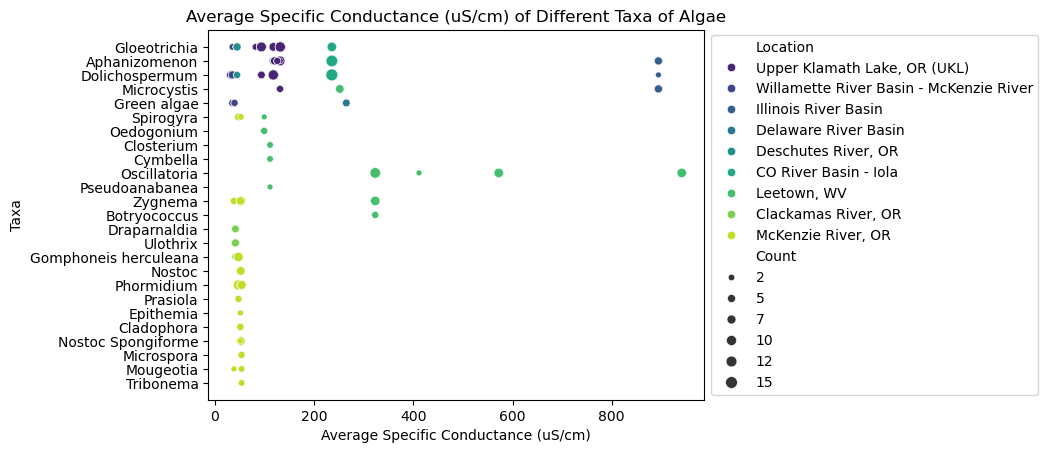

In [6]:
# FINAL 
# plot of specific conductance by taxa, size determines how many samples taken at that location with that spec cond, color determines location of sample
sns.scatterplot(cond_morph_with_counts, y='Morphological_ID', x='AvgSCond', size='Count', hue='Location', palette='viridis')
plt.xlabel("Average Specific Conductance (uS/cm)")
plt.ylabel("Taxa")
plt.title("Average Specific Conductance (uS/cm) of Different Taxa of Algae")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig('scatterplot.png', bbox_inches='tight')
plt.show

In [7]:
ranges = cond_morph_with_counts.groupby('Morphological_ID')['AvgSCond'].agg(['min','max'])
ranges['range'] = ranges['max'] - ranges['min']
print(ranges['range'].sort_values())

Morphological_ID
Microspora                 0.00
Pseudoanabanea             0.00
Oedogonium                 0.00
Ulothrix                   0.00
Draparnaldia               0.00
Prasiola                   0.00
Cymbella                   0.00
Closterium                 0.00
Botryococcus               0.00
Tribonema                  0.00
Epithemia                  1.00
Nostoc Spongiforme         1.00
Cladophora                 1.00
Nostoc                     4.80
Gomphoneis herculeana      6.20
Phormidium                 6.30
Mougeotia                 15.50
Spirogyra                 51.90
Gloeotrichia             200.65
Green algae              231.05
Zygnema                  285.00
Oscillatoria             618.00
Microcystis              763.00
Aphanizomenon            776.50
Dolichospermum           862.19
Name: range, dtype: float64


In [8]:
cond_morph_with_counts['Location'].value_counts()

Location
McKenzie River, OR                         87
Upper Klamath Lake, OR (UKL)               75
Leetown, WV                                54
CO River Basin - Iola                      37
Willamette River Basin - McKenzie River    26
Clackamas River, OR                        12
Illinois River Basin                       11
Deschutes River, OR                         8
Delaware River Basin                        4
Name: count, dtype: int64

In [9]:
cond_morph_with_counts.groupby('Location')['AvgSCond'].sum()['Leetown, WV']/54

np.float64(408.9111111111111)

In [10]:
ranges = cond_morph_with_counts.groupby('Morphological_ID')['AvgSCond'].agg(['min','max'])
ranges['range'] = ranges['max'] - ranges['min']
print(ranges['range'].sort_values())

Morphological_ID
Microspora                 0.00
Pseudoanabanea             0.00
Oedogonium                 0.00
Ulothrix                   0.00
Draparnaldia               0.00
Prasiola                   0.00
Cymbella                   0.00
Closterium                 0.00
Botryococcus               0.00
Tribonema                  0.00
Epithemia                  1.00
Nostoc Spongiforme         1.00
Cladophora                 1.00
Nostoc                     4.80
Gomphoneis herculeana      6.20
Phormidium                 6.30
Mougeotia                 15.50
Spirogyra                 51.90
Gloeotrichia             200.65
Green algae              231.05
Zygnema                  285.00
Oscillatoria             618.00
Microcystis              763.00
Aphanizomenon            776.50
Dolichospermum           862.19
Name: range, dtype: float64


In [11]:
ranges = cond_morph_with_counts.groupby('Location')['AvgSCond'].agg(['min','max'])
ranges['range'] = ranges['max'] - ranges['min']
print(ranges['range'].sort_values())

Location
CO River Basin - Iola                        0.00
Clackamas River, OR                          0.00
Delaware River Basin                         0.00
Deschutes River, OR                          0.00
Illinois River Basin                         0.00
Willamette River Basin - McKenzie River      7.52
McKenzie River, OR                          15.50
Upper Klamath Lake, OR (UKL)                50.00
Leetown, WV                                841.90
Name: range, dtype: float64


In [ ]:
# function to standardize graphs
def graph_geo(df, states, col, size = None, color = None, edge = None, legend=True, title=None):
    geometry = gpd.points_from_xy(df['Long'], df['Lat'])
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    fig, ax = plt.subplots(figsize=(10, 8))
    states.plot(ax=ax, color='white', edgecolor='black')
    if legend:
        gdf.plot(column=col, ax=ax, cmap = color, edgecolor=edge, legend=True, markersize = size, legend_kwds={'bbox_to_anchor': (1.3, 1),'title':title})
    else:
        gdf.plot(column=col, ax=ax, cmap = color, edgecolor=edge, legend=True, markersize = size)

In [13]:
# creating bins for specific conductance

# custom bins:
# 0-31 -> 0-11, 12-21, 22-31
# 32-43
# 44-54

bins=field_data.sort_values(by='AvgSCond').reset_index(drop=True)
cond_1 = bins[0:12] # 30.36 - 39.33
cond_2 = bins[12:22] # 41.00 - 47.20
cond_3 = bins[22:32] # 51.00 - 53.5
cond_4 = bins[32:44] # 81.5 - 131.5
cond_5 = bins[45:55] # 251.50 - 941.00

def bin_data(row):
    val = row['AvgSCond']
    if val <= 39.33:
        return "0 to 39.33"
    elif val <= 47.20:
        return "39.33 to 47.20"
    elif val <= 53.5:
        return "47.20 to 53.5"
    elif val <= 131.5:
        return "53.5 to 131.5"
    else:
        return "131.5 and up"

# add bin information to cond_morph_with_counts
binned_cond_data = cond_morph_with_counts
binned_cond_data['bin'] = binned_cond_data.apply(bin_data, axis=1)
binned_cond_data


,Sample_ID,Location,Long,Lat,AvgSCond,Morphological_ID,Count,bin
0,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Gloeotrichia,6,53.5 to 131.5
1,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Aphanizomenon,5,53.5 to 131.5
2,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Dolichospermum,10,53.5 to 131.5
3,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Gloeotrichia,6,53.5 to 131.5
4,RPT_01,"Upper Klamath Lake, OR (UKL)",-121.857150,42.344360,117.5,Aphanizomenon,5,53.5 to 131.5
...,...,...,...,...,...,...,...,...
309,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium,7,47.20 to 53.5
310,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium,7,47.20 to 53.5
311,FRRA_G,"McKenzie River, OR",-122.368061,44.142939,53.5,Phormidium,7,47.20 to 53.5
312,FRRA_H,"McKenzie River, OR",-122.368061,44.142939,53.5,Tribonema,2,47.20 to 53.5


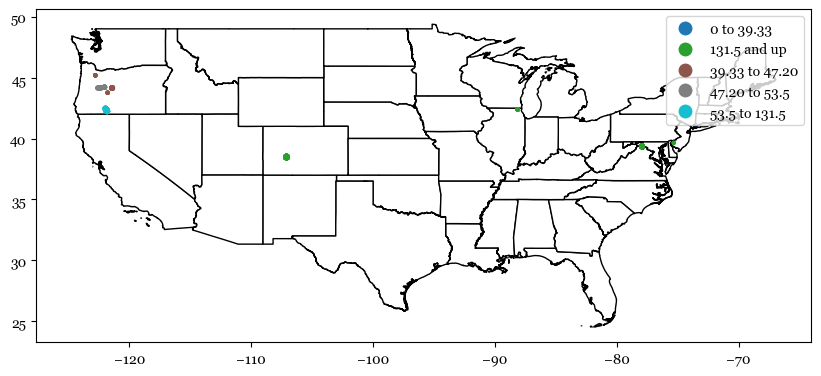

In [ ]:
# TEST 
graph_geo(binned_cond_data, states, 'bin', size=binned_cond_data['Count'], legend=False)

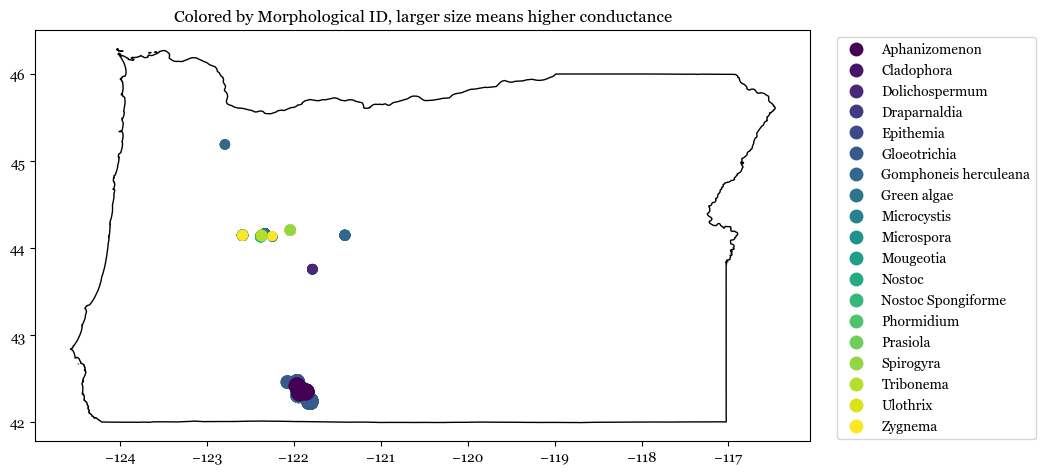

In [ ]:
# NOT USED
bin_oregon = binned_cond_data[binned_cond_data['Long'] < -120]
# bin_oregon['bin'] *= 25
bin_oregon['Count'] *= 5
graph_geo(bin_oregon, oregon, 'Morphological_ID', size=bin_oregon['AvgSCond'], color='viridis')
plt.title("Colored by Morphological ID, larger size means higher conductance")
plt.show()

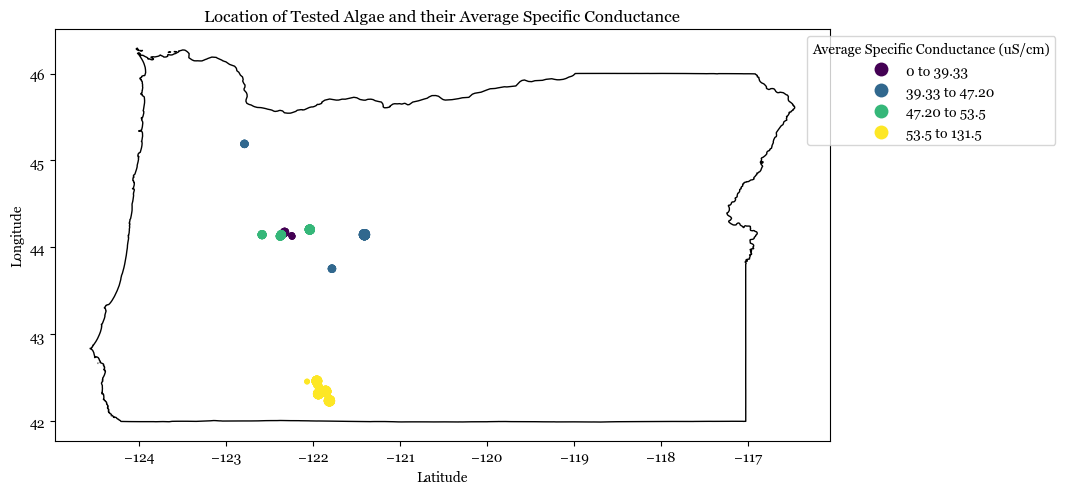

In [ ]:
# changed font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Georgia'] + plt.rcParams['font.serif']

# FINAL
graph_geo(bin_oregon, oregon, 'bin', color='viridis', size=bin_oregon['Count'],title='Average Specific Conductance (uS/cm)')
plt.title("Location of Tested Algae and their Average Specific Conductance") # larger size relates to more algae tested at one location
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.savefig('oregon.png',bbox_inches='tight')
plt.show()

In [26]:
def round_100(row):
    return str(round(row['AvgSCond'],-2))

In [28]:
bin_wv1 = cond_morph_with_counts[cond_morph_with_counts['Long'] > -79]
bin_wv = bin_wv1[bin_wv1['Long'] < -77]
bin_wv['Count'] *= 5
bin_wv['bin'] = bin_wv.apply(round_100, axis=1)
bin_wv

C:\Users\etu89\AppData\Local\Temp\ipykernel_37912\541440028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_wv['Count'] *= 5
C:\Users\etu89\AppData\Local\Temp\ipykernel_37912\541440028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_wv['bin'] = bin_wv.apply(round_100, axis=1)


,Sample_ID,Location,Long,Lat,AvgSCond,Morphological_ID,Count,bin
161,LT_P5,"Leetown, WV",-77.9344,39.35391,99.1,Spirogyra,5,100.0
162,LT_P5,"Leetown, WV",-77.9344,39.35391,99.1,Oedogonium,15,100.0
163,LT_P5,"Leetown, WV",-77.9344,39.35391,99.1,Oedogonium,15,100.0
164,LT_P5,"Leetown, WV",-77.9344,39.35391,99.1,Oedogonium,15,100.0
165,LT_P8,"Leetown, WV",-77.9351,39.35400,110.9,Closterium,10,100.0
166,LT_P8,"Leetown, WV",-77.9351,39.35400,110.9,Closterium,10,100.0
167,LT_P8,"Leetown, WV",-77.9351,39.35400,110.9,Cymbella,10,100.0
168,LT_P8,"Leetown, WV",-77.9351,39.35400,110.9,Cymbella,10,100.0
169,LT_P15,"Leetown, WV",-77.9357,39.35097,941.0,Oscillatoria,40,900.0
170,LT_P15,"Leetown, WV",-77.9357,39.35097,941.0,Oscillatoria,40,900.0


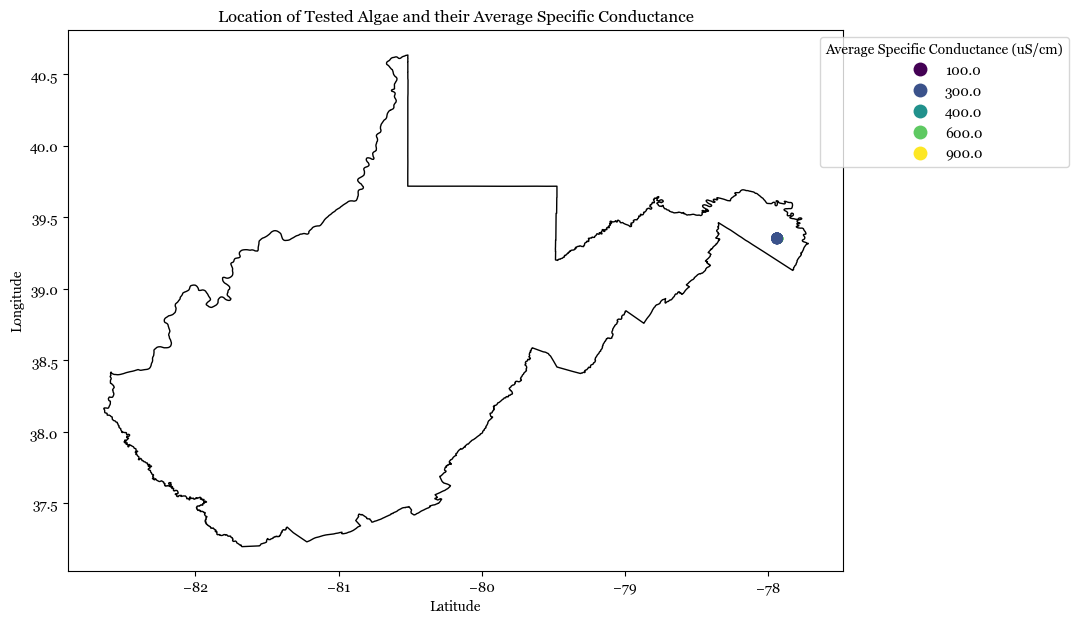

In [ ]:
# NOT USED
graph_geo(bin_wv, w_virginia, 'bin', color='viridis', size=bin_wv['Count'],title='Average Specific Conductance (uS/cm)')
plt.title("Location of Tested Algae and their Average Specific Conductance") # larger size relates to more algae tested at one location
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.savefig('wv.png',bbox_inches='tight')
plt.show()

##### Statistical Analysis

In [33]:
# map if a taxa is harmful based on state
# 1 is harmful, 0 is not harmful
# https://www.epa.gov/habs/learn-about-harmful-algae-cyanobacteria-and-cyanotoxins 
co_harmful_map = {'Aphanizomenon': 1, 'Gloeotrichia': 1, 'Dolichospermum': 1}
or_harmful_map = {'Aphanizomenon': 1, 'Cladophora': 0, 'Dolichospermum': 1, 'Draparnaldia': 0, 'Epithemia': 0, 'Gloeotrichia': 1, 'Gomphoneis herculeana': 0, 'Green algae': 0, 'Microcystis': 1, 'Microspora': 0, 'Mougeotia': 0, 'Nostoc': 0, 'Nostoc Spongiforme': 0, 'Phormidium': 0, 'Prasiola': 0, 'Spirogyra': 0, 'Tribonema': 0, 'Ulothrix': 0, 'Zygnema': 0}
de_harmful_map = {'Green algae': 0}
il_harmful_map = {'Aphanizomenon': 1, 'Microcystis': 1, 'Dolichospermum': 1}
wv_harmful_map = {'Spirogyra': 0, 'Oedogonium': 0, 'Closterium': 0, 'Cymbella': 0, 'Oscillatoria': 0, 'Microcystis': 1, 'Pseudoanabanea': 0, 'Zygnema': 0,'Botryococcus': 0}
harmful_map = {**co_harmful_map, **or_harmful_map, **de_harmful_map, **il_harmful_map, **wv_harmful_map}

cond_morph_with_counts['Harmfulness'] = cond_morph_with_counts['Morphological_ID'].map(harmful_map)

In [34]:
# point biserial correlation for all locations
correlation_result = pointbiserialr(cond_morph_with_counts['Harmfulness'], cond_morph_with_counts['AvgSCond'])

correlation_coefficient = correlation_result.statistic
p_value = correlation_result.pvalue

print(f"Point Biserial Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Point Biserial Correlation Coefficient: 0.06808283528689299
P-value: 0.22897022200845119


In [35]:
or_cond = duckdb.sql("""SELECT * FROM cond_morph_with_counts
                     WHERE Location = 'Upper Klamath Lake, OR (UKL)' 
                     OR Location = 'Willamette River Basin - McKenzie River' 
                     OR Location = 'Deschutes River, OR'
                     OR Location = 'Clackamas River, OR'
                     OR Location = 'McKenzie River, OR' """).df()
or_cond['Harmful'] = or_cond['Morphological_ID'].map(or_harmful_map)

In [36]:
# point biserial correlation for oregon only
correlation_result = pointbiserialr(or_cond['Harmfulness'], or_cond['AvgSCond'])

correlation_coefficient = correlation_result.statistic
p_value = correlation_result.pvalue

print(f"Point Biserial Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Point Biserial Correlation Coefficient: 0.7103164337676926
P-value: 2.992501070382036e-33


In [37]:
wv_cond = duckdb.sql("""SELECT * FROM cond_morph_with_counts
                     WHERE Location = 'Leetown, WV' """).df()
wv_cond['Harmful'] = wv_cond['Morphological_ID'].map(wv_harmful_map)

In [38]:
# point biserial correlation for west virginia only
correlation_result = pointbiserialr(wv_cond['Harmfulness'], wv_cond['AvgSCond'])

correlation_coefficient = correlation_result.statistic
p_value = correlation_result.pvalue

print(f"Point Biserial Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Point Biserial Correlation Coefficient: -0.21504379609289814
P-value: 0.11838254003100936


In [60]:
harm_counts = cond_morph_with_counts.groupby('Sample_ID')['Harmfulness'].sum()
cond_data_with_counts['Harmfulness_count'] = cond_data_with_counts['Sample_ID'].map(harm_counts).fillna(0)

cond_data_with_counts

,Sample_ID,Location,Site_Name,Site_ID,Lat,Long,Sampling_Date,Sampling_Time,Timezone,USGS_siteno,AvgSCond,Notes,Count,Harmfulness_count
0,RPT_01,"Upper Klamath Lake, OR (UKL)",Rattlesnake Point,RPT,42.344360,-121.857150,7/5/2022,8:55:00 AM,PDT,0.000000e+00,117.50,"Partly sunny, no wind. Averaged from 2 samples...",21,21.0
1,WRM,"Upper Klamath Lake, OR (UKL)",Williamson River Mouth,WRM,42.463540,-121.958830,7/5/2022,9:30:00 AM,PDT,0.000000e+00,93.50,"Partly sunny, no wind. Averaged from 2 samples...",13,13.0
2,PB,"Upper Klamath Lake, OR (UKL)",Pelican Bay,PB,42.457420,-122.071390,7/5/2022,10:35:00 AM,PDT,0.000000e+00,81.50,"Partly sunny, no wind. Averaged from 2 samples...",2,2.0
3,RPT_02,"Upper Klamath Lake, OR (UKL)",Rattlesnake Point,RPT,42.344304,-121.858196,7/25/2022,9:50:00 AM,PDT,0.000000e+00,122.50,Barometric Pressure taken from office not fiel...,4,4.0
4,HB_01,"Upper Klamath Lake, OR (UKL)",Howard Bay,HB,42.315390,-121.941946,7/25/2022,9:20:00 AM,PDT,0.000000e+00,131.00,Barometric Pressure taken from office not fiel...,12,12.0
5,MP,"Upper Klamath Lake, OR (UKL)",Moore Park,MP,42.235901,-121.813987,7/25/2022,10:05:00 AM,PDT,0.000000e+00,131.50,Barometric Pressure taken from office not fiel...,11,11.0
6,MDT,"Upper Klamath Lake, OR (UKL)",Mid Trench,MDT,42.386070,-121.929740,8/1/2022,9:00:00 AM,PDT,0.000000e+00,120.00,"Barometric pressure: from office, not field. O...",5,5.0
7,SB,"Upper Klamath Lake, OR (UKL)",Shoalwater Bay,SB,42.414020,-121.960290,8/1/2022,9:21:00 AM,PDT,0.000000e+00,125.50,"Barometric pressure: from office, not field. O...",3,3.0
8,HB_02,"Upper Klamath Lake, OR (UKL)",Howard Bay,HB,42.331470,-121.934240,8/1/2022,8:35:00 AM,PDT,0.000000e+00,120.00,"Barometric pressure: from office, not field. 5...",4,4.0
9,CP,"Deschutes River, OR","Crane Prairie Reservoir Near La Pine,Oreg",CP,43.755300,-121.785000,7/13/2022,9:46:00 AM,PDT,1.405350e+07,44.32,"DO%: Local 648.4 mmHg, DO% Read 3 taken 7/13/2...",8,8.0


In [59]:
# pearson correlation 

# x is number of harmful algae
correlation_coefficient, p_value = pearsonr(cond_data_with_counts['Harmfulness_count'], cond_data_with_counts['AvgSCond'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.1132233440231411
P-value: 0.4104786624371665


In [62]:
or_cond_count = duckdb.sql("""SELECT * FROM cond_data_with_counts
                     WHERE Location = 'Upper Klamath Lake, OR (UKL)' 
                     OR Location = 'Willamette River Basin - McKenzie River' 
                     OR Location = 'Deschutes River, OR'
                     OR Location = 'Clackamas River, OR'
                     OR Location = 'McKenzie River, OR' """).df()
# or_cond_count['Harmfulness'] = or_cond['Morphological_ID'].map(or_harmful_map)

In [63]:
# pearson correlation 

# x is number of harmful algae
correlation_coefficient, p_value = pearsonr(or_cond_count['Harmfulness_count'], or_cond_count['AvgSCond'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.6547999091130585
P-value: 3.406230725402153e-06


In [66]:
wv_cond_count = cond_data_with_counts[cond_data_with_counts['Location'] == 'Leetown, WV']

In [67]:
# pearson correlation 

# x is number of harmful algae
correlation_coefficient, p_value = pearsonr(wv_cond_count['Harmfulness_count'], wv_cond_count['AvgSCond'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.12492231311870589
P-value: 0.7309571583565777
